In [1]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as  plt
#%matplotlib inline jupyternotebook中必须加上这句才能显示图片
import numpy as np
import pandas as pd
import sklearn
import os
import sys
import time
from tensorflow import keras
#import keras
print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__,module.__version__)

2.2.0
sys.version_info(major=3, minor=6, micro=9, releaselevel='final', serial=0)
matplotlib 3.2.2
numpy 1.18.5
pandas 1.0.5
sklearn 0.22.2.post1
tensorflow 2.2.0
tensorflow.keras 2.3.0-tf


In [2]:
df_clean = pd.read_csv("./total_data.csv" )

In [3]:
#---------------------------------------------------------------------------------------
given_ingredient = list(df_clean.ingredients)[0:192]


#-----------------------------创建评估用词表--------------------------------------------
reference_recipe = list(df_clean.recipes)
reference_meteor = []
references = []
reference_list = reference_recipe[0:192]
for astr in reference_list:
    alist = astr.split(' ')[1:-1]
    reference_meteor.append(' '.join(alist))
    references.append([alist])

In [4]:
clean_summaries = list(df_clean.ingredients)
clean_texts = list(df_clean.recipes)
print(clean_summaries[-1])
print(clean_texts[-1])

<start> egg yolks white sugar eggnog heavy whipping cream vanilla extract white sugar <end>
<start> preheat oven to 350 degrees f 175 degrees c . whisk egg yolks and 1 tablespoon sugar together in a bowl until sugar is dissolved . whisk in eggnog , cream , and vanilla extract until thoroughly combined . pour eggnog mixture into 4 ramekins . place ramekins in baking dish pour in enough boiling water to come half way up the sides of ramekins . bake in the preheated oven until set , about 1 hour . cool slightly , cover ramekins with plastic wrap , and refrigerate at least 4 hours . set oven rack about 6 inches from the heat source and preheat the oven s broiler . remove plastic wrap from ramekins . sprinkle 1 tablespoon of sugar in a thin layer over top of each ramekin . brown the sugar using a kitchen torch or under a broiler until golden and caramelized , 30 seconds to 1 minute . <end>


In [5]:
sp_dataset = tuple(clean_summaries)
en_dataset = tuple(clean_texts)

In [6]:
df_clean.head(5)

,ingredients,recipes
0,<start> skinless boneless chicken breast butte...,"<start> place the chicken , butter , soup , an..."
1,<start> condensed cream mushroom soup package ...,"<start> in a slow cooker , mix cream of mushro..."
2,<start> purpose flour baking soda salt butter ...,<start> preheat oven to 350 degrees f 175 degr...
3,<start> butter softened white sugar eggs vanil...,"<start> in a large bowl , cream together butte..."
4,<start> purpose flour baking soda salt unsalte...,<start> preheat the oven to 325 degrees f 165 ...


In [7]:
#将词语式数据转成ID式
def tokenizer(lang):
    lang_tokenizer = keras.preprocessing.text.Tokenizer(
        num_words=None, filters='', split=' ')
    lang_tokenizer.fit_on_texts(lang)#统计词频，生成词表
    tensor = lang_tokenizer.texts_to_sequences(lang)
    tensor = keras.preprocessing.sequence.pad_sequences(tensor, padding='post')#在句子后面做padding
    return tensor, lang_tokenizer
#不一定要在两个tokenizer里有一样的index
input_tensor, input_tokenizer = tokenizer(sp_dataset)
output_tensor, output_tokenizer = tokenizer(en_dataset)
# print(type(input_tensor))
# print(output_tensor.shape)

def max_length(tensor):
    return max(len(t) for t in tensor)

max_length_input = max_length(input_tensor)
max_length_output = max_length(output_tensor)
print(max_length_input, max_length_output)

35 216


In [8]:
from sklearn.model_selection import train_test_split
input_train, input_eval, output_train, output_eval = train_test_split(input_tensor[192:], output_tensor[192:], test_size=0.01, shuffle=False)

len(input_train), len(input_eval), len(output_train), len(output_eval)

(18781, 190, 18781, 190)

In [9]:
#验证tokenizer正常工作
def convert(example, tokenizer):
    for t in example:
        if t != 0:
            print('%d -- > %s' % (t, tokenizer.index_word[t]))
convert(input_train[0], input_tokenizer)
print()
convert(output_train[0], output_tokenizer)

1 -- > <start>
27 -- > pound
5 -- > chopped
17 -- > fresh
259 -- > broccoli
94 -- > cubed
103 -- > cooked
35 -- > chicken
292 -- > meat
78 -- > condensed
15 -- > cream
259 -- > broccoli
92 -- > soup
14 -- > milk
36 -- > shredded
72 -- > cheddar
11 -- > cheese
7 -- > butter
62 -- > melted
47 -- > dried
63 -- > bread
124 -- > crumbs
2 -- > <end>

11 -- > <start>
42 -- > preheat
17 -- > oven
7 -- > to
604 -- > 450
14 -- > degrees
30 -- > f
654 -- > 230
14 -- > degrees
31 -- > c
1 -- > .
24 -- > place
4 -- > the
504 -- > broccoli
6 -- > in
5 -- > a
75 -- > saucepan
9 -- > with
261 -- > enough
41 -- > water
7 -- > to
55 -- > cover
1 -- > .
78 -- > bring
7 -- > to
5 -- > a
68 -- > boil
2 -- > ,
3 -- > and
33 -- > cook
63 -- > 5
10 -- > minutes
2 -- > ,
25 -- > or
8 -- > until
113 -- > tender
1 -- > .
103 -- > drain
1 -- > .
24 -- > place
4 -- > the
178 -- > cooked
504 -- > broccoli
6 -- > in
5 -- > a
290 -- > 9
53 -- > inch
171 -- > pie
249 -- > plate
1 -- > .
58 -- > top
9 -- > with
4 -- > 

In [10]:
batch_size = 64
epochs = 20
dataset = tf.data.Dataset.from_tensor_slices((input_train, output_train))
train_dataset = dataset.repeat(epochs).batch(batch_size, drop_remainder= True)
#24000
train_dataset = train_dataset.shuffle(10000)
eval_dataset = tf.data.Dataset.from_tensor_slices((input_eval, output_eval))
eval_dataset = eval_dataset.repeat(epochs).batch(batch_size, drop_remainder= True)

In [11]:
for x, y in train_dataset.take(1):
    print(x.shape)
    print(y.shape)
    print(x)
    print(y)

(64, 35)
(64, 216)
tf.Tensor(
[[  1  51 109 ...   0   0   0]
 [  1  20  12 ...   0   0   0]
 [  1  16  50 ...   0   0   0]
 ...
 [  1  46 111 ...   0   0   0]
 [  1 452 588 ...   0   0   0]
 [  1 283   6 ...   0   0   0]], shape=(64, 35), dtype=int32)
tf.Tensor(
[[ 11  42  17 ...   0   0   0]
 [ 11  28   4 ...   0   0   0]
 [ 11  42  17 ...   0   0   0]
 ...
 [ 11 169   4 ...   0   0   0]
 [ 11  52 441 ...   0   0   0]
 [ 11   6   5 ...   0   0   0]], shape=(64, 216), dtype=int32)


In [12]:
embedding_units = 256
units = 256
#input_tokenizer.word_index是个字典
input_vocab_size = len(input_tokenizer.word_index) + 1
output_vocab_size = len(output_tokenizer.word_index) + 1
print(input_vocab_size,output_vocab_size)

3492 6728


In [ ]:
class Encoder(keras.Model):
    def __init__(self, vocab_size, embedding_units, encoding_units, batch_size):
        super(Encoder, self).__init__()
        self.batch_size = batch_size
        self.encoding_units = encoding_units
        self.embedding = keras.layers.Embedding(vocab_size, embedding_units)
        #由于用attention，每步输出需要return_sequences = True
        self.gru = keras.layers.GRU(self.encoding_units,
                                   return_sequences = True,
                                   return_state = True,
                                   recurrent_initializer = 'glorot_uniform')
        
        
    #hidden是初始化的隐含状态
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_size, self.encoding_units))
    
encoder = Encoder(input_vocab_size, embedding_units, units, batch_size)
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder.call(x, sample_hidden)

print('sample_output.shape: ', sample_output.shape)
print('sample_hidden.shape: ', sample_hidden.shape)

sample_output.shape:  (64, 35, 256)
sample_hidden.shape:  (64, 256)


In [13]:
#-------------------lstm-----------------------------------
class Encoder(keras.Model):
    def __init__(self, vocab_size, embedding_units, encoding_units, batch_size):
        super(Encoder, self).__init__()
        self.batch_size = batch_size
        self.encoding_units = encoding_units
        self.embedding = keras.layers.Embedding(vocab_size, embedding_units)
        #由于用attention，每步输出需要return_sequences = True
        self.gru = keras.layers.LSTM(self.encoding_units,
                                   return_sequences = True,
                                   return_state = True,
                                   recurrent_initializer = 'glorot_uniform')
        
        
    #hidden是初始化的隐含状态
    #这里hidden应该变成[hiddenstate,hiddenc]
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state, state_c = self.gru(x, initial_state = hidden)
        return output, state, state_c
    
    def initialize_hidden_state(self):
        return [tf.zeros((self.batch_size, self.encoding_units)),tf.zeros((self.batch_size, self.encoding_units))]
    
encoder = Encoder(input_vocab_size, embedding_units, units, batch_size)
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden, sample_c = encoder.call(x, sample_hidden)

print('sample_output.shape: ', sample_output.shape)
print('sample_hidden.shape: ', sample_hidden.shape)
print('sample_memory.shape: ', sample_c.shape)

sample_output.shape:  (64, 35, 256)
sample_hidden.shape:  (64, 256)
sample_memory.shape:  (64, 256)


In [ ]:
class Decoder(keras.Model):
    def __init__(self, vocab_size, embedding_units, decoding_units, batch_size):
        super(Decoder, self).__init__()#调用父类（keras.Model）的构造函数
        self.batch_size = batch_size
        self.decoding_units = decoding_units
        self.embedding = keras.layers.Embedding(vocab_size, embedding_units)
        self.gru = keras.layers.GRU(self.decoding_units,
                                   return_sequences = True,
                                   return_state = True,
                                   recurrent_initializer = 'glorot_uniform')
        
        self.fc = keras.layers.Dense(vocab_size)
        
        
        #x:当前步输入，hidden:前一步输出
    def call(self, x, hidden, encoding_outputs, encoding_hidden):
        #context_vector.shape: (bathc_size, units)
        #context_vector = encoding_hidden
        #befor embedding:x.shape:(batch_size, 1)
        #after embedding:x.shape:(batch_size, 1, embedding_units)
        
        combined_x = self.embedding(x)
        
        #combined_x = tf.concat([tf.expand_dims(context_vector, 1),x], axis = -1)
        
        #output.shape: (batch_size, 1, decoding_units)
        #state.shape: (batch_size, decoding_units)
        output, state = self.gru(combined_x,initial_state = hidden)
        
        #output.shape: (batch_size, decoding_units)
        output = tf.reshape(output, (-1, output.shape[2]))
        
        #output.shape: (batch_size, vocab_size)
        output = self.fc(output)
        
        return output, state
decoder = Decoder(output_vocab_size, embedding_units, units, batch_size)

outputs = decoder.call(tf.random.uniform((batch_size,1)), sample_hidden, sample_output, sample_hidden)

decoder_output, decoder_hidden = outputs

print(decoder_output.shape)
print(decoder_hidden.shape)

(64, 6728)
(64, 256)


In [14]:
#-----------------------lstm----------------------------------
class Decoder(keras.Model):
    def __init__(self, vocab_size, embedding_units, decoding_units, batch_size):
        super(Decoder, self).__init__()#调用父类（keras.Model）的构造函数
        self.batch_size = batch_size
        self.decoding_units = decoding_units
        self.embedding = keras.layers.Embedding(vocab_size, embedding_units)
        self.gru = keras.layers.LSTM(self.decoding_units,
                                   return_sequences = True,
                                   return_state = True,
                                   recurrent_initializer = 'glorot_uniform')
        
        self.fc = keras.layers.Dense(vocab_size)
        
        
        #x:当前步输入，hidden:前一步输出
    def call(self, x, hidden, encoding_outputs, encoding_state):
        #context_vector.shape: (bathc_size, units)
        #context_vector = encoding_hidden
        #befor embedding:x.shape:(batch_size, 1)
        #after embedding:x.shape:(batch_size, 1, embedding_units)
        
        combined_x = self.embedding(x)
        
        #combined_x = tf.concat([tf.expand_dims(context_vector, 1),x], axis = -1)
        
        #output.shape: (batch_size, 1, decoding_units)
        #state.shape: (batch_size, decoding_units)
        output, state, state_c = self.gru(combined_x,initial_state = [hidden,encoding_state])
        
        #output.shape: (batch_size, decoding_units)
        output = tf.reshape(output, (-1, output.shape[2]))
        
        #output.shape: (batch_size, vocab_size)
        output = self.fc(output)
        
        return output, state, state_c
decoder = Decoder(output_vocab_size, embedding_units, units, batch_size)

outputs = decoder.call(tf.random.uniform((batch_size,1)), sample_hidden, sample_output, sample_hidden)

decoder_output, decoder_hidden, decoder_state_c = outputs

print(decoder_output.shape)
print(decoder_hidden.shape)
print(decoder_state_c.shape)

(64, 6728)
(64, 256)
(64, 256)


In [ ]:
tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam', **kwargs
)

In [15]:
optimizer = keras.optimizers.Adam()
#optimizer = keras.optimizers.RMSprop()

loss_object = keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction = 'none')
#from_logits直接经过fc的输出没有经过softmax,如果经过softmax就设成False

def loss_function(real, pred):
    #输出里的padding不应该计算到损失函数中去
    mask = tf.math.logical_not(tf.math.equal(real, 0))#是padding时，mask取0
    loss_ = loss_object(real, pred)
    #将mask变为loss类型
    mask = tf.cast(mask, dtype = loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_mean(loss_)

In [ ]:
@tf.function#加速cell
def train_step(inp, targ, encoding_hidden):
    loss = 0
    with tf.GradientTape() as tape:
        encoding_outputs, encoding_hidden = encoder(inp, encoding_hidden)
        
        decoding_hidden = encoding_hidden
        
        #eg: <start> I am here <end>
        #1. <start> -> I
        #2. I -> am
        #3. am -> here
        #4. here -> <end>
        for t in range(0, targ.shape[1]-1):
          #decoding_input为64个sample中的第t个单词shape =（64，1）
            decoding_input = tf.expand_dims(targ[:, t],1)
            predictions, decoding_hidden = decoder.call(decoding_input, decoding_hidden, encoding_outputs, encoding_hidden)
            #t+1是为了不去到一开始的start，相当于targ中值集体后移一个单位
            #prediction是预测值，targ[:t+1]是label
            loss += loss_function(targ[:, t+1],predictions)
            
    batch_loss = loss / int(targ.shape[0])
        
    variables = encoder.trainable_variables + decoder.trainable_variables
        
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
        
    return batch_loss 

In [16]:
#lstm-----------------------------------------
@tf.function#加速cell
def train_step(inp, targ, encoding_hidden):
    loss = 0
    with tf.GradientTape() as tape:
        encoding_outputs, encoding_hidden, encoding_c = encoder(inp, encoding_hidden)
        
        decoding_hidden = encoding_hidden
        decoding_state = encoding_c
        #eg: <start> I am here <end>
        #1. <start> -> I
        #2. I -> am
        #3. am -> here
        #4. here -> <end>
        for t in range(0, targ.shape[1]-1):
            decoding_input = tf.expand_dims(targ[:, t],1)
            predictions, decoding_hidden, decoding_state = decoder.call(decoding_input, decoding_hidden, encoding_outputs, decoding_state)
            loss += loss_function(targ[:, t+1],predictions)
            
    batch_loss = loss / int(targ.shape[0])
        
    variables = encoder.trainable_variables + decoder.trainable_variables
        
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
        
    return batch_loss    

In [ ]:
def eval_step(inp, targ, encoding_hidden):
    loss = 0
    
    encoding_outputs, encoding_hidden = encoder(inp, encoding_hidden)
        
    decoding_hidden = encoding_hidden
        
        #eg: <start> I am here <end>
        #1. <start> -> I
        #2. I -> am
        #3. am -> here
        #4. here -> <end>
    for t in range(0, targ.shape[1]-1):
        decoding_input = tf.expand_dims(targ[:, t],1)
        predictions, decoding_hidden = decoder.call(decoding_input, decoding_hidden, encoding_outputs, encoding_hidden)
        loss += loss_function(targ[:, t+1],predictions)
            
    batch_loss = loss / int(targ.shape[0])
    return batch_loss 

In [17]:
#-------------------------------------------lstm-------------------------
def eval_step(inp, targ, encoding_hidden):
    loss = 0
    
    encoding_outputs, encoding_hidden, encoding_c = encoder(inp, encoding_hidden)
        
    decoding_hidden = encoding_hidden
    decoding_state = encoding_c
        #eg: <start> I am here <end>
        #1. <start> -> I
        #2. I -> am
        #3. am -> here
        #4. here -> <end>
    for t in range(0, targ.shape[1]-1):
        decoding_input = tf.expand_dims(targ[:, t],1)
        predictions, decoding_hidden, decoding_state = decoder.call(decoding_input, decoding_hidden, encoding_outputs, decoding_state)
        loss += loss_function(targ[:, t+1],predictions)
            
    batch_loss = loss / int(targ.shape[0])
    return batch_loss 

In [18]:
adict = {'training_loss':[], 'validation_loss':[]}
alist = []
import time
epochs = 20
# steps_per_epoch = len(input_tensor[192:18973]) // batch_size
# steps_per_epoch1 = len(input_tensor[18973:]) // batch_size
steps_per_epoch = len(input_train) // batch_size
steps_per_epoch1 = len(input_eval) // batch_size
for epoch in range(epochs):
    start = time.time()
    
    encoding_hidden = encoder.initialize_hidden_state()
    total_loss = 0
    total_loss1 = 0
    for (batch, (inp, targ)) in enumerate(train_dataset.take(steps_per_epoch)):
        
        batch_loss = train_step(inp, targ, encoding_hidden)
        total_loss += batch_loss
        
        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:4f}'.format(epoch+1, batch, batch_loss.numpy()))
    for (batch1, (inp, targ)) in enumerate(eval_dataset.take(steps_per_epoch1)):
        eval_loss = eval_step(inp, targ, encoding_hidden)
        total_loss1 += eval_loss
               
            
      
    print('Epoch {} Loss {:4f}'.format(epoch+1, total_loss / steps_per_epoch))
    print('Epoch {} Eval_Loss {:4f}'.format(epoch+1, total_loss1 / steps_per_epoch1))
    print('Time take for 1 epoch {} sec\n'.format(time.time() - start))
    adict['training_loss'].append(round(float(total_loss / steps_per_epoch),3))
    adict['validation_loss'].append(round(float(total_loss1 / steps_per_epoch1),3))

Epoch 1 Batch 0 Loss 12.461626
Epoch 1 Batch 100 Loss 7.400144
Epoch 1 Batch 200 Loss 6.462569
Epoch 1 Loss 7.280476
Epoch 1 Eval_Loss 6.458149
Time take for 1 epoch 303.9668242931366 sec

Epoch 2 Batch 0 Loss 6.495558
Epoch 2 Batch 100 Loss 5.956728
Epoch 2 Batch 200 Loss 5.265969
Epoch 2 Loss 5.254271
Epoch 2 Eval_Loss 5.145291
Time take for 1 epoch 96.7593502998352 sec

Epoch 3 Batch 0 Loss 4.464046
Epoch 3 Batch 100 Loss 4.040629
Epoch 3 Batch 200 Loss 4.232018
Epoch 3 Loss 4.409122
Epoch 3 Eval_Loss 4.671593
Time take for 1 epoch 96.77343678474426 sec

Epoch 4 Batch 0 Loss 4.474987
Epoch 4 Batch 100 Loss 4.011635
Epoch 4 Batch 200 Loss 4.445597
Epoch 4 Loss 4.040303
Epoch 4 Eval_Loss 4.383228
Time take for 1 epoch 96.71013712882996 sec

Epoch 5 Batch 0 Loss 3.877162
Epoch 5 Batch 100 Loss 3.166957
Epoch 5 Batch 200 Loss 3.538884
Epoch 5 Loss 3.783489
Epoch 5 Eval_Loss 4.186955
Time take for 1 epoch 96.3666582107544 sec

Epoch 6 Batch 0 Loss 3.387730
Epoch 6 Batch 100 Loss 3.269960

In [23]:
print(adict)

{'training_loss': [7.28, 5.254, 4.409, 4.04, 3.783, 3.591, 3.451, 3.328, 3.218, 3.132, 3.085, 3.016, 2.955, 2.891, 2.835, 2.815, 2.768, 2.729, 2.696, 2.66], 'validation_loss': [6.458, 5.145, 4.672, 4.383, 4.187, 4.052, 3.942, 3.857, 3.779, 3.753, 3.685, 3.644, 3.614, 3.595, 3.555, 3.554, 3.569, 3.527, 3.495, 3.517]}


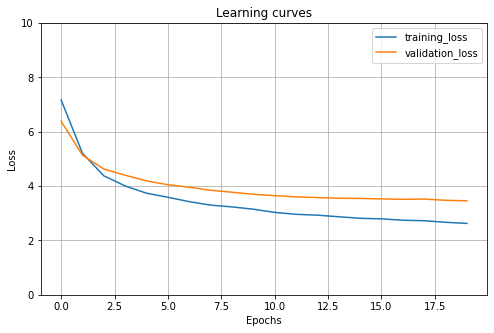

In [20]:
import matplotlib.pyplot as  plt
def plot_learning_curves(history, title=None):
    pd.DataFrame(history).plot(figsize=(8,5))
    plt.title('Learning curves')
    plt.grid(True)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.gca().set_ylim(0,10) #设置坐标轴范围, x轴范围是epochs的个数
    plt.show()
plot_learning_curves(adict)

In [ ]:
def evaluate(input_sentence):
    
    inputs = [input_tokenizer.word_index[token] for token in input_sentence.split(' ')]
    inputs = keras.preprocessing.sequence.pad_sequences(
    [inputs], maxlen=max_length_input, padding='post')
    
    inputs = tf.convert_to_tensor(inputs)
    results = ''
    #encoding_hidden = encoder.initialize_hidden_state()
    encoding_hidden = tf.zeros((1,units))
    
    encoding_outputs, encoding_hidden = encoder(inputs, encoding_hidden)
    decoding_hidden = encoding_hidden
    #eg: <start> I am here <end>
        #1. <start> -> I
        #2. I -> am
        #3. am -> here
        #4. here -> <end>
    #decoding_inpu.shape :(1,1)(batch_size, length)
    decoding_input = tf.expand_dims([output_tokenizer.word_index['<start>']],0)
    for t in range(max_length_output):
        #attention_weights.shape: (batch_size, input_length, 1)(1,16,1)
        predictions, decoding_hidden = decoder(decoding_input, decoding_hidden, encoding_outputs, encoding_hidden)
        
        #predictions.shape: (batch_size, vocab_size)  (1,4935)
        predicted_id = tf.argmax(predictions[0]).numpy()
        results += output_tokenizer.index_word[predicted_id] + ' '
        if output_tokenizer.index_word[predicted_id] == '<end>':
            return results, input_sentence
        
        decoding_input = tf.expand_dims([predicted_id],0)
    return results, input_sentence

def plot_attention(attention_matrix, input_sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1,1,1)#add a subplot,1,1,1表示子图位置
    ax.matshow(attention_matrix, cmap='viridis')#viridis是一种配色方案
    
    font_dict = {'fontsize': 14}
    ax.set_xticklabels([''] + input_sentence, fontdict=font_dict, rotation = 90)#seq2seq里不需要加空格
    ax.set_yticklabels([''] + predicted_sentence, fontdict=font_dict)
    plt.show()

def translate(input_sentence):
    results, input_sentence = evaluate(input_sentence)
    
    #------------------------
    
    print('Input: %s' % (input_sentence))
    print('Predicted translation: %s' % (results))
    
    #attention_matrix = attention_matrix[:len(results.split(' ')), :len(input_sentence.split(' '))]
    
    #plot_attention(attention_matrix, input_sentence.split(' '), results.split(' '))
    return results

In [20]:
#----------------------lstm---------------------------------------
def evaluate(input_sentence):
    
    inputs = [input_tokenizer.word_index[token] for token in input_sentence.split(' ')]
    inputs = keras.preprocessing.sequence.pad_sequences(
    [inputs], maxlen=max_length_input, padding='post')
    
    inputs = tf.convert_to_tensor(inputs)
    results = ''
    #encoding_hidden = encoder.initialize_hidden_state()
    encoding_hidden = [tf.zeros((1,units)),tf.zeros((1,units))]
    
    encoding_outputs, encoding_hidden, encoding_c = encoder(inputs, encoding_hidden)
    decoding_hidden = encoding_hidden
    decoding_state = encoding_c
    #eg: <start> I am here <end>
        #1. <start> -> I
        #2. I -> am
        #3. am -> here
        #4. here -> <end>
    #decoding_inpu.shape :(1,1)(batch_size, length)
    decoding_input = tf.expand_dims([output_tokenizer.word_index['<start>']],0)
    for t in range(max_length_output):
        #attention_weights.shape: (batch_size, input_length, 1)(1,16,1)
        predictions, decoding_hidden, decoding_state = decoder(decoding_input, decoding_hidden, encoding_outputs, decoding_state)
        
        #predictions.shape: (batch_size, vocab_size)  (1,4935)
        predicted_id = tf.argmax(predictions[0]).numpy()
        results += output_tokenizer.index_word[predicted_id] + ' '
        if output_tokenizer.index_word[predicted_id] == '<end>':
            return results, input_sentence
        
        decoding_input = tf.expand_dims([predicted_id],0)
    return results, input_sentence

def plot_attention(attention_matrix, input_sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1,1,1)#add a subplot,1,1,1表示子图位置
    ax.matshow(attention_matrix, cmap='viridis')#viridis是一种配色方案
    
    font_dict = {'fontsize': 14}
    ax.set_xticklabels([''] + input_sentence, fontdict=font_dict, rotation = 90)#seq2seq里不需要加空格
    ax.set_yticklabels([''] + predicted_sentence, fontdict=font_dict)
    plt.show()

def translate(input_sentence):
    results, input_sentence = evaluate(input_sentence)
    
    #------------------------
    
    print('Input: %s' % (input_sentence))
    print('Predicted translation: %s' % (results))
    
    #attention_matrix = attention_matrix[:len(results.split(' ')), :len(input_sentence.split(' '))]
    
    #plot_attention(attention_matrix, input_sentence.split(' '), results.split(' '))
    return results

In [21]:
#----------------------BLEU and Meteor------------------------------
candidates = []
candidates_meteor = []
for sample1 in clean_summaries[0:192]:
    #res = translate(sample1+', ')
    res = translate(sample1)
    candidates_meteor.append(res)
    candidates.append(res.split(' '))

Input: <start> skinless boneless chicken breast butter condensed cream chicken soup onion finely diced refrigerated biscuit dough torn pieces <end>
Predicted translation: preheat oven to 350 degrees f 175 degrees c . grease a 9x13 inch baking dish . in a large bowl , mix together the chicken , onion , and onion . mix well . in a large bowl , mix the soup and milk . mix well . pour the mixture into the prepared baking dish . bake in the preheated oven until the cheese is melted and the cheese is melted , about 20 minutes . <end> 
Input: <start> condensed cream mushroom soup package dry onion soup mix water pot roast <end>
Predicted translation: preheat oven to 350 degrees f 175 degrees c . grease a 9x13 inch baking dish . in a large bowl , mix together the ground beef , onion soup mix , and soup mix well . pour the mixture into the prepared baking dish . bake in the preheated oven until the cheese is melted and the cheese is melted , about 20 minutes . <end> 
Input: <start> purpose flou

In [22]:
# two references for one document
from nltk.translate.bleu_score import corpus_bleu
score = corpus_bleu(references, candidates,weights=(1,0,0,0))
score1 = corpus_bleu(references, candidates,weights=(0.33,0.33,0.33,0))
score2 = corpus_bleu(references, candidates,weights=(0.25,0.25,0.25,0.25))
print(score,score1,score2)

0.42502651597128815 0.18865265916759796 0.13495881692460582


In [27]:
def calculate_given_item(given_ingredient, generated_recipe):
    '''
    given_ingredient = ['egg tomatoes','chicken']
    splitted_ingredient = [['egg','tomatoes'],['chicken']]
    generated_recipe = [['use','egg'],['use','chicken'],...]
    '''
    
    total_score = 0
    extra_score = 0
    splitted_ingredient = []
    for bstr in given_ingredient: 
        splitted_ingredient.append(bstr.split(' '))
    

    for index, each_sample in enumerate(splitted_ingredient):
        #count1 covered items
        #count2 extra items
        count1 = 0
        count2 = 0
        for each_word in each_sample:
            #generated_recipe就是下面的candidates=[['use','egg'],['use','chicken'],...]
            if each_word in generated_recipe[index]:
                count1 += 1
            else:
                count2 += 1
        extra_score += count2 / len(each_sample)
        total_score += count1 / len(each_sample)
#-------------------------------------------------------------------------
    for index, each_recipe in enumerate(generated_recipe):
        #count1 covered items
        #count2 extra items
        extra_item = 0
        for each_word in each_recipe:
            #generated_recipe就是下面的candidates=[['use','egg'],['use','chicken'],...]
            if each_word in input_tokenizer.word_index and each_word not in splitted_ingredient[index]:
                extra_item += 1
                  
#--------------------------------------------------------------------------      
    
    total_score = total_score / len(given_ingredient)
    
    return total_score, extra_item

'''
#testing set
given_ingredient = ['egg tomatoes','chicken banana']
generated_recipe = [['tomatoes','use'],['banana','chicken']]
cover_item, extra_item = calculate_given_item(given_ingredient, generated_recipe)
print(cover_item,extra_item)
'''

"\n#testing set\ngiven_ingredient = ['egg tomatoes','chicken banana']\ngenerated_recipe = [['tomatoes','use'],['banana','chicken']]\ncover_item, extra_item = calculate_given_item(given_ingredient, generated_recipe)\nprint(cover_item,extra_item)\n"

In [31]:
cover_item, extra_item = calculate_given_item(given_ingredient, candidates)
print(cover_item,extra_item)

0.25918759501752103 40


In [29]:
print(reference_meteor)

['place the chicken , butter , soup , and onion in a slow cooker , and fill with enough water to cover . cover , and cook for 5 to 6 hours on high . about 30 minutes before serving , place the torn biscuit dough in the slow cooker . cook until the dough is no longer raw in the center .', 'in a slow cooker , mix cream of mushroom soup , dry onion soup mix and water . place pot roast in slow cooker and coat with soup mixture . cook on high setting for 3 to 4 hours , or on low setting for 8 to 9 hours .', 'preheat oven to 350 degrees f 175 degrees c . lightly grease a 9x5 inch loaf pan . in a large bowl , combine flour , baking soda and salt . in a separate bowl , cream together butter and brown sugar . stir in eggs and mashed bananas until well blended . stir banana mixture into flour mixture stir just to moisten . pour batter into prepared loaf pan . bake in preheated oven for 60 to 65 minutes , until a toothpick inserted into center of the loaf comes out clean . let bread cool in pan f

In [30]:
print(candidates_meteor)

['preheat oven to 350 degrees f 175 degrees c . place chicken breasts in a 9x13 inch baking dish . pour in the soy sauce , and pour over the chicken . cover , and bake for 30 minutes . drain the chicken and discard the marinade . place the chicken breasts into the prepared baking dish . bake in the preheated oven until the chicken is no longer pink in the center , about 30 minutes . an instant read thermometer inserted into the center should read at least 165 degrees f 74 degrees c . <end> ', 'preheat oven to 350 degrees f 175 degrees c . in a medium bowl , mix together the mayonnaise , sour cream , and onion . mix well and pour into a 9x13 inch baking dish . bake in the preheated oven until the cheese is melted and the cheese is melted , about 30 minutes . <end> ', 'preheat oven to 350 degrees f 175 degrees c . grease and flour a 9 inch round cake pan . in a large bowl , cream together the butter and sugar until light and fluffy . beat in the eggs one at a time , then stir in the vani

In [23]:
translate(u'<start> water white salt tomatoes oil <end>')

TypeError: ignored

In [ ]:
translate(u'skinless boneless chicken breast butter condensed cream chicken soup onion finely diced refrigerated biscuit dough torn pieces, ')
translate(u'condensed cream mushroom soup package dry onion soup mix water pot roast, ')
translate(u'purpose flour baking soda salt butter brown sugar eggs beaten mashed overripe bananas, ')

Input: <start> skinless boneless chicken breast butter condensed cream chicken soup onion finely diced refrigerated biscuit dough torn pieces <end>
Predicted translation: preheat oven to 350 degrees c . <end> 
Input: <start> condensed cream mushroom soup package dry onion soup mix water pot roast <end>
Predicted translation: in a slow cooker . <end> 
Input: <start> purpose flour baking soda salt butter brown sugar eggs beaten mashed overripe bananas <end>
Predicted translation: preheat the flour , and salt . in the flour , and salt . in the flour , and salt . in the flour , and salt . in the flour , and salt . in the flour , and salt . in the flour , and salt . in the flour , and salt . in the flour , and salt . in the flour , and salt . in the flour , and salt . in the flour , and salt . in the flour , and salt . in the flour , and salt . in the flour , and salt . in the flour , and salt . in the flour , and salt . in the flour , and salt . in the flour , and salt . in the flour , and

'preheat the flour , and salt . in the flour , and salt . in the flour , and salt . in the flour , and salt . in the flour , and salt . in the flour , and salt . in the flour , and salt . in the flour , and salt . in the flour , and salt . in the flour , and salt . in the flour , and salt . in the flour , and salt . in the flour , and salt . in the flour , and salt . in the flour , and salt . in the flour , and salt . in the flour , and salt . in the flour , and salt . in the flour , and salt . in the flour , and salt . in the flour , and salt . in the flour , and salt . in the flour , and salt . in the flour , and salt . in the flour , and salt . in the flour , and salt . in the flour , and salt . in the flour , and salt . in the flour , and salt . in the flour , and salt . in the flour , and salt '